# Анализ корректности проведения  A/B теста и его результатов

## Цели и задачи проекта: 

1. Оценить корректность проведения теста
   - удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
   - проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.
2. Проанализировать результаты теста

## Описание данных: 

В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

**Техническое Задание:**
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    1. конверсии в просмотр карточек товаров — событие product_page
    2. просмотры корзины — product_cart
    3. покупки — purchase.

**Данные:**

#### /datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

#### /datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

#### /datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

#### /datasets/final_ab_participants.csv — таблица участников тестов.
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

## Описание процесса анализа :

1. Исследовать данные 

    
2. Оценить корректность проведения теста. Обратить внимание на:
    - Соответствие данных требованиям технического задания. Проверить корректность всех пунктов ТЗ.
    - Время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.
    - Проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.
    
      
3. Провести исследовательский анализ данных:
    - Как количество событий на пользователя распределено в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Понять, есть-ли особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию?
    
     
4. Провести оценку результатов A/B-тестирования:
    - Проверить статистическую разницу долей z-критерием.
    
       
5. Общий вывод

In [147]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

from scipy import stats as st
import numpy as np
import math as mth

In [148]:
import warnings
warnings.filterwarnings('ignore')

## 1. Загрузим и исследуем данные: 

In [149]:
try:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
    new_users = pd.read_csv('final_ab_new_users.csv')
    events = pd.read_csv('final_ab_events.csv')
    ab_participants = pd.read_csv('final_ab_participants.csv')
except: 
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

#### Исследуем marketing_events:

In [150]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [151]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [152]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [153]:
marketing_events.duplicated().sum()

0

In [154]:
# Переведем даты в datetime:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


#### Исследуем new_users:

In [155]:
 new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [156]:
 new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [157]:
 new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [158]:
 new_users.duplicated().sum()

0

перевести дату в datetime

In [159]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

#### Исследуем events:

In [160]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [161]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [162]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [163]:
events.duplicated().sum()

0

- Сделать отдельный столбец с датой в формате datetime
- Пропуски в details - это нормально, тк может не быть дополнительной информации по типу события

In [164]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info()
# events['date']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [165]:
events['date'] = events['event_dt'].dt.date
events.head()

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


#### Исследуем ab_participants:

In [166]:
ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [167]:
ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [168]:
ab_participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [169]:
ab_participants.duplicated().sum()

0

### Вывод по итогам изучения данных: 
- столбцы со временем переведены в datetime64 + создан отдельный столбей с датой в events
- явных дуюликатов не обнаружено
- пропуски есть только в таблице events в колонке details - это нормально, тк может не быть доп. информации по типу события

## 2. Оценить корректность проведения теста:

### 2.1 Соответствие данных требованиям технического задания
Проверим корректность всех пунктов технического задания:

**Техническое Задание:**
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    1. конверсии в просмотр карточек товаров — событие product_page
    2. просмотры корзины — product_cart
    3. покупки — purchase.

#### Название теста: recommender_system_test;

In [170]:
ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [171]:
ab_participants.head(1)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test


In [172]:
ab_participants.groupby(['ab_test'],as_index=False)['user_id'].count()

,ab_test,user_id
0,interface_eu_test,11567
1,recommender_system_test,6701


В данных смешались пользователи и группы из 2х тестов. Данных по интересующему нас тесту 6701 строк.

In [173]:
participants_all_users = ab_participants.merge(new_users, left_on='user_id', right_on='user_id')

In [174]:
# Оставим только нужный тест : 
ab_participants = ab_participants[ab_participants['ab_test'] == 'recommender_system_test']
ab_participants.shape[0]

6701

#### Дата запуска: 2020-12-07;

In [175]:
# Объединим очищенный participants c new_users:
participants_new_users = ab_participants.merge(new_users, left_on='user_id', right_on='user_id')
participants_new_users.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [176]:
participants_new_users[participants_new_users['region'] == 'EU']['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Минимальная дата регистрации пользователя соответствует.

#### Дата остановки набора новых пользователей: 2020-12-21;

In [177]:
participants_new_users[participants_new_users['region'] == 'EU']['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Дата остановки набора новых пользователей - тоже соответствует.

#### Дата остановки: 2021-01-04;

In [178]:
participants_new_users_events = participants_new_users.merge(events, how='left', on='user_id')
participants_new_users_events.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


In [179]:
participants_new_users_events[participants_new_users_events['region'] == 'EU']['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

Последнее событие зарегистрировано 2020-12-30 - соответствует ТЗ

#### Аудитория: 15% новых пользователей из региона EU;

In [180]:
# Кол-во уникальных пользователей из Европы c нашим тестом
our_test_eu_users = participants_new_users[participants_new_users['region'] == 'EU']['user_id'].nunique()

In [181]:
# Кол-во уникальных пользователей из Европы до 21 числа включительно, в таблице final_ab_new_users(new_users)
all_eu_users = new_users[(new_users['region'] == 'EU') & (new_users['first_date'] <= '2020-12-21')]['user_id'].nunique()

In [182]:
print('Доля пользователей региона Европа в данных: ',our_test_eu_users/all_eu_users*100,'%')

Доля пользователей региона Европа в данных:  15.0 %


Доля пользователей более 15% - соответствует условиям

#### Ожидаемое количество участников теста: 6000:

In [183]:
print(
    'Кол-во участников теста:',
    participants_new_users_events[participants_new_users_events['region'] == 'EU']['user_id'].nunique())

Кол-во участников теста: 6351


In [184]:
# Оставим в данных только регион Европа: 
participants_new_users_events = participants_new_users_events[participants_new_users_events['region'] == 'EU']

#### Ожидаемый эффект: 
#### за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    1. конверсии в просмотр карточек товаров — событие product_page
    2. просмотры корзины — product_cart
    3. покупки — purchase.

In [185]:
participants_new_users_events['lifetime'] = (
   participants_new_users_events['event_dt'] - participants_new_users_events['first_date']
).dt.days
participants_new_users_events.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,0.0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25,18.0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,0.0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25,18.0
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07,0.0


In [186]:
result_grouped = participants_new_users_events.pivot_table(
    index=['first_date'], columns='lifetime', values='user_id', aggfunc='nunique'
)

result_grouped

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
first_date,,,,,,,,,,,,,,,,,,,,,
2020-12-07,311.0,129.0,103.0,75.0,56.0,47.0,39.0,36.0,25.0,29.0,...,17.0,15.0,12.0,15.0,16.0,15.0,18.0,8.0,14.0,2.0
2020-12-08,132.0,68.0,41.0,25.0,13.0,20.0,16.0,16.0,12.0,9.0,...,4.0,5.0,12.0,4.0,4.0,2.0,2.0,6.0,NaN,NaN
2020-12-09,161.0,72.0,37.0,33.0,27.0,18.0,16.0,18.0,18.0,15.0,...,14.0,5.0,11.0,9.0,4.0,5.0,9.0,NaN,NaN,NaN
2020-12-10,92.0,36.0,21.0,8.0,8.0,8.0,14.0,11.0,6.0,6.0,...,5.0,3.0,2.0,2.0,4.0,4.0,NaN,NaN,NaN,NaN
2020-12-11,106.0,45.0,37.0,18.0,14.0,6.0,16.0,10.0,7.0,7.0,...,2.0,8.0,4.0,3.0,8.0,NaN,NaN,NaN,NaN,NaN
2020-12-12,111.0,38.0,32.0,16.0,16.0,12.0,15.0,13.0,7.0,10.0,...,6.0,9.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-13,66.0,19.0,15.0,8.0,13.0,2.0,5.0,7.0,3.0,3.0,...,4.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-14,434.0,218.0,150.0,104.0,77.0,79.0,55.0,55.0,56.0,42.0,...,32.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-15,233.0,97.0,76.0,50.0,58.0,40.0,34.0,21.0,24.0,23.0,...,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
# Оставим в данных только lifetime 14 дней и менее:
participants_new_users_events = participants_new_users_events[participants_new_users_events['lifetime'] <= 14]

### 2.2 Время проведения теста
Убедимся, что оно не совпадает с маркетинговыми и другими активностями.

In [188]:
marketing_events.sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


- Наш тест проводился с 2020-12-07 по 2021-01-04 , при этом последняя дата события 2020-12-30
- Конец нашего периода совпадает с проведением в EU и N.America компании 'Christmas&New Year Promo', которая проходила с 2020-12-25 по 2021-01-03. 
- Данное пересечение могло повлиять на рез-ты нашего теста, стоит подумать над исключением событий произошедших после 2020-12-25 и далее.
- Таким образом в наш тест должны попасть пользователили, которые прожили 14 дней с моменты регистрации и события до 2020-12-25 

In [189]:
# посмотрим сколько событий до и после 2020-12-25:
all_test_events = participants_new_users_events['event_dt'].count()
event_before_2020_12_25 = participants_new_users_events[participants_new_users_events['event_dt'] >= '2020-12-25']['event_dt'].count()
print('Кол-во событий всего: ',all_test_events)
print('Кол-во событий включая и после 2020-12-25: ',event_before_2020_12_25)
print('Мы теряем % событий = ', round((event_before_2020_12_25/all_test_events*100),1))

Кол-во событий всего:  22828
Кол-во событий включая и после 2020-12-25:  2711
Мы теряем % событий =  11.9


### 2.3 Проверим аудиторию теста: 
#### Проверим наличие пересечений с конкурирующим тестом и убедимся что нет пользователей, участвующих в двух группах теста одновременно. 

In [190]:
# Наличие пересечений с конкурирующим тестом:
participants_all_users.groupby('user_id').agg({'ab_test' : 'nunique'}).query('ab_test>1').count()

ab_test    1602
dtype: int64

In [191]:
# Наличие пользователей, участвующих в двух группах теста одновременно:
ab_participants.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()

group    0
dtype: int64

In [192]:
(
    ab_participants[ab_participants['ab_test'] == 'recommender_system_test']
    .groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()
)

group    0
dtype: int64

#### Посмотрим кол-во уникальных польз-лей в каждой группе:

In [193]:
unique_users_cnt = participants_new_users_events.groupby('group',as_index=False)['user_id'].nunique()
unique_users_cnt

,group,user_id
0,A,2604
1,B,877


### Вывод: 
- Пересечений по группам нашего теста НЕТ.
- Есть пересечения пользователей нашего теста с другим. Что может влиять на результаты нашего теста.
- Группы достаточно большие и разница в кол-ве пользователей не критична для проведения теста

## 3. Исследовательский анализ данных:

###  3.1 Посмотрим как в выборках распределено количество событий на пользователя ?

In [194]:
events_by_users = participants_new_users_events.groupby(['group','user_id'],as_index=False)['event_name'].count()
events_by_users.head()

,group,user_id,event_name
0,A,0010A1C096941592,12
1,A,00341D8401F0F665,2
2,A,003DF44D7589BBD4,15
3,A,00505E15A9D81546,5
4,A,006E3E4E232CE760,6


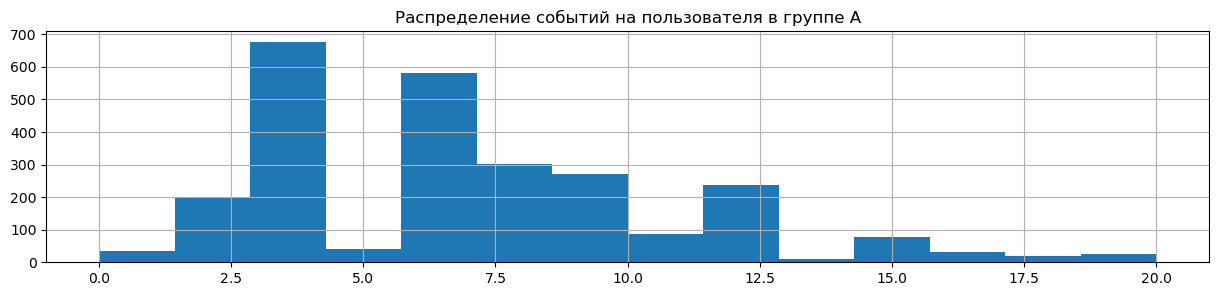

In [195]:
events_by_users[events_by_users['group']== 'A']['event_name'].hist(figsize = (15,3),bins=14, range=(0,20))
plt.title('Распределение событий на пользователя в группе А')
plt.show()

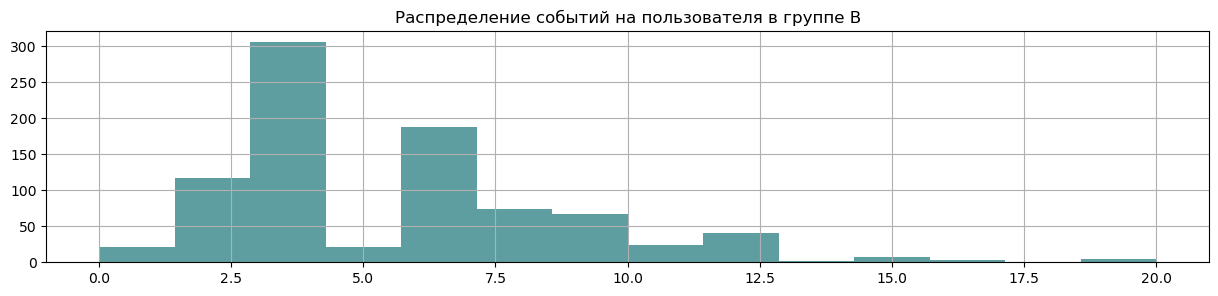

In [196]:
events_by_users[events_by_users['group']== 'B']['event_name'].hist(figsize = (15,3),bins=14, range=(0,20),color = "#5F9EA0")
plt.title('Распределение событий на пользователя в группе B')
plt.show()

In [197]:
print('Среднее кол-во событий в группе А:',events_by_users[events_by_users['group']== 'A']['event_name'].mean())
print('Среднее кол-во событий в группе B:',events_by_users[events_by_users['group']== 'B']['event_name'].mean())
print('Медиана событий в группе А:',events_by_users[events_by_users['group']== 'A']['event_name'].median())
print('Медиана событий в группе B:',events_by_users[events_by_users['group']== 'B']['event_name'].median())

Среднее кол-во событий в группе А: 6.903609831029186
Среднее кол-во событий в группе B: 5.531356898517674
Медиана событий в группе А: 6.0
Медиана событий в группе B: 4.0


### Вывод:
Кол-во событий по группам А и В распределено более-менее равномерно.

### 3.2 Как число событий в выборках распределено по дням?

In [198]:
events_by_date = participants_new_users_events.groupby(['date','group'],as_index=False)['event_name'].count()
events_by_date.head()

,date,group,event_name
0,2020-12-07,A,318
1,2020-12-07,B,356
2,2020-12-08,A,313
3,2020-12-08,B,238
4,2020-12-09,A,371


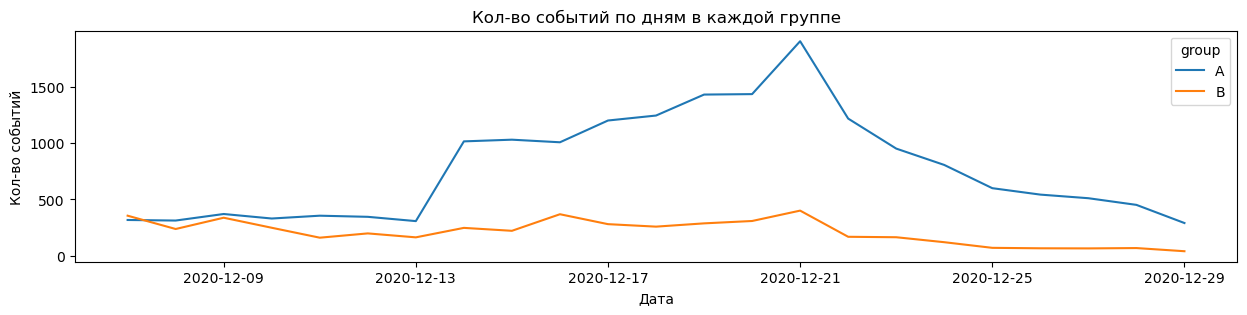

In [199]:
plt.figure(figsize=(15,3))
sns.lineplot(data=events_by_date, x='date', y='event_name', hue='group')
plt.title('Кол-во событий по дням в каждой группе')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.show()

In [200]:
participants_new_users_events.groupby(['group','event_name'])['event_name'].count()

group  event_name  
A      login           7968
       product_cart    2385
       product_page    5125
       purchase        2499
B      login           2345
       product_cart     625
       product_page    1257
       purchase         624
Name: event_name, dtype: int64

### 3.3 Как меняется конверсия в воронке в выборках на разных этапах?

In [201]:
 row_group_sales_funnel = (
     participants_new_users_events.pivot_table(index='group',columns = 'event_name', values='user_id',aggfunc='nunique')
     .reset_index()
 )
row_group_sales_funnel

event_name,group,login,product_cart,product_page,purchase
0,A,2604,782,1685,833
1,B,876,244,493,249


In [202]:
group_sales_funnel = row_group_sales_funnel.merge(unique_users_cnt,left_on='group', right_on='group')
group_sales_funnel =  group_sales_funnel[['group','user_id','login','product_page','product_cart','purchase']]
group_sales_funnel

,group,user_id,login,product_page,product_cart,purchase
0,A,2604,2604,1685,782,833
1,B,877,876,493,244,249


In [203]:
group_sales_funnel['login_share'] = round(group_sales_funnel['login'] / group_sales_funnel['user_id'] * 100, 1)
group_sales_funnel['pp_share'] = round(group_sales_funnel['product_page'] / group_sales_funnel['user_id'] * 100, 1)
group_sales_funnel['cart_share'] = round(group_sales_funnel['product_cart'] / group_sales_funnel['user_id'] * 100, 1)
group_sales_funnel['purchase_share'] = round(group_sales_funnel['purchase'] / group_sales_funnel['user_id'] * 100, 1)
group_sales_funnel

,group,user_id,login,product_page,product_cart,purchase,login_share,pp_share,cart_share,purchase_share
0,A,2604,2604,1685,782,833,100.0,64.7,30.0,32.0
1,B,877,876,493,244,249,99.9,56.2,27.8,28.4


- На каждои этапе воронки конверсия снижается примерно в 2 раза к прошлому этапу.
- При этом показатели в группе B более чем в 2 раза хуже чем в группе А
- Больше всего пользователей теряется на этапе регистрация - логин
    - в группе А этот показатель ~ 30%
    - в группе В ~ 70 

In [204]:
login_group_sales_funnel = row_group_sales_funnel[['group','login','product_page','product_cart','purchase']]
login_group_sales_funnel

event_name,group,login,product_page,product_cart,purchase
0,A,2604,1685,782,833
1,B,876,493,244,249


In [205]:
login_group_sales_funnel['pp_share'] = round(login_group_sales_funnel['product_page'] / login_group_sales_funnel['login'] * 100, 1)
login_group_sales_funnel['cart_share'] = round(login_group_sales_funnel['product_cart'] / login_group_sales_funnel['login'] * 100, 1)
login_group_sales_funnel['purchase_share'] = round(login_group_sales_funnel['purchase'] / login_group_sales_funnel['login'] * 100, 1)
login_group_sales_funnel

event_name,group,login,product_page,product_cart,purchase,pp_share,cart_share,purchase_share
0,A,2604,1685,782,833,64.7,30.0,32.0
1,B,876,493,244,249,56.3,27.9,28.4


In [206]:
df_a = login_group_sales_funnel.drop(index=1,columns=['group','pp_share','cart_share','purchase_share']).transpose().reset_index()
df_a['group'] = 'А'
df_a.columns = ['event_name','cnt','group']

df_b = login_group_sales_funnel.drop(index=0,columns=['group','pp_share','cart_share','purchase_share']).transpose().reset_index()
df_b['group'] = 'B'
df_b.columns = ['event_name','cnt','group']

df_ab = pd.concat([df_a, df_b], axis=0)

In [207]:
fig = px.funnel(df_ab, x='cnt', y='event_name', color='group')
fig.update_layout(title_text='Доля пользователей совершивших событие:', title_x=0.5)
fig.show()

### Вывод:
- Если смотреть показатели конверсии с этапа login, поскольку в ТЗ нас интересует конверсия начиная с этапа просмотра карточек, то:
    1. С этапа логин, до просмотра карточки теряется ~ 40% польз-лей
    2. С этапа просмотра карточки до просмотра в корзину теряется ~ 50% польз-лей
    3. С этапа простомтра корзины до этапа покупки доля пользователей немного растет!!!
    
    
- Получается что этап просмотра корзины снижает конверсию. Пользователи могут купить и не просматривая её

## 4. Проведем оценку результатов A/B-тестирования:

### 4.1 Проверим статистическую разницу долей z-критерием

In [208]:
# Напишем функцию для проверки гипотезы о равенстве долей:
def hypotesis(df,index1, index2, column1,column_unique_cnt, alpha = 0.05):
    """ 
    df - (DataFrame) - название датафрейма из которого берем данные 
    index1 (int) - индекс, указывающий 1ую группу теста
    index2 (int) - индекс, указывающий 2ую группу теста
    column1 (series,int) - название столбца для расчета пропорций в наблюдаемых выборках
    column_unique_cnt (series,int) - название столбца с общим размером выборки
    alpha (float) - критический уровень статистической значимости 
    
    """
    p1 = df.iloc[index1][column1] / df.iloc[index1][column_unique_cnt]
    p2 = df.iloc[index2][column1] / df.iloc[index2][column_unique_cnt]
    
    p_combined = (
        (df.iloc[index1][column1] + df.iloc[index2][column1]) /
        (df.iloc[index1][column_unique_cnt] + df.iloc[index2][column_unique_cnt])
    )
    
    difference = p1 - p2
    
    z_value = (
        difference / mth.sqrt(p_combined * (1 - p_combined) * 
                              (1/df.iloc[index1][column_unique_cnt] +
                               1/df.iloc[index2][column_unique_cnt]))
    )
    
    distr = st.norm(0,1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [209]:
login_group_sales_funnel

event_name,group,login,product_page,product_cart,purchase,pp_share,cart_share,purchase_share
0,A,2604,1685,782,833,64.7,30.0,32.0
1,B,876,493,244,249,56.3,27.9,28.4


In [210]:
alpha = 0.05
# ТК проводим 3 теста, необходимо применить поправку Бонферрони:
fixed_alpha = alpha/3

In [211]:
hypotesis(login_group_sales_funnel,0,1,'product_page','login',fixed_alpha)

p-значение:  8.195976000324734e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [212]:
hypotesis(login_group_sales_funnel,0,1,'product_cart','login',fixed_alpha)

p-значение:  0.2215941567364419
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [213]:
hypotesis(login_group_sales_funnel,0,1,'purchase','login',fixed_alpha)

p-значение:  0.04864766695042433
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<a id="conclusion"></a>
## 5. Общий вывод:

1. Тест проведен не совсем корректно, тк часть критериев ТЗ не выполнена: 
    - Есть пересечение теста с другой маркетинговой компанией
    - Есть пересечение пользователей с другим тестом
    - Кол-во пользователей в тесте сильно меньше ожидаемого
2. По результатам проведенного теста ожидания об улучшение каждой метрики не менее, чем на 10% НЕ оправдались.